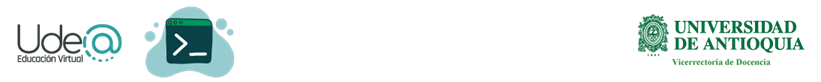

# Laboratorio Regresión Lineal
## Parte B: Regularización, Inferencia y Regresión Bayesiana

**Laboratorio Tratamiento de Señales III** *Práctica* 09

**Laboratorio: Laboratorio Regresión Lineal Parte B**

*   Mateo Muñoz Arroyave
CC 1036676919

*   David Esteban Londoño Patiño
CC 1020465536

**Facultad de Ingeniería**

**Universidad de Antioquia**

---

# Sobreentrenamiento

Como vimos en la parte A del laboratorio de regresión lineal, el estimador de máxima verosimilitud es propenso al sobreentrenamiento.

Recordemos la definición del modelo que establece la correspondencia entre los datos de entrada $\textbf{x}_n$ con los datos de salida $y_n$

$$
\begin{align}
y_n &= f(\textbf{x}_n, \boldsymbol{\theta}) + \epsilon, \\
y_n &= \sum_{k = 0}^K \theta_k \phi_k(\textbf{x}_n) + \epsilon,
\end{align}
$$

donde los datos de entrada son $\textbf{x}_n \in \mathbb{R}^D$, y los datos de salida corresponden a $ y_n \in \mathbb{R}$.

In [1]:
import numpy as np
import scipy as sp
import sklearn as skl
import matplotlib.pyplot as plt

Iniciemos generando una base de datos sintética

In [2]:
# generar base de datos sintética
np.random.seed(0)
Ntrain = 35 # número de observaciones
Ntest = 1000 # cantidad datos de entrenamiento

sigma = 0.05 # desviación estandar del ruido
Xtrain = np.linspace(-3, 3, Ntrain).reshape(-1, 1) # datos de entrada
ytrain = np.sinc(Xtrain) + np.random.normal(size=(Xtrain.shape), scale=sigma) # datos de salida

Xtest = np.linspace(-3, 3, Ntest).reshape(-1, 1) # datos de entrada
ytest= np.sinc(Xtest)

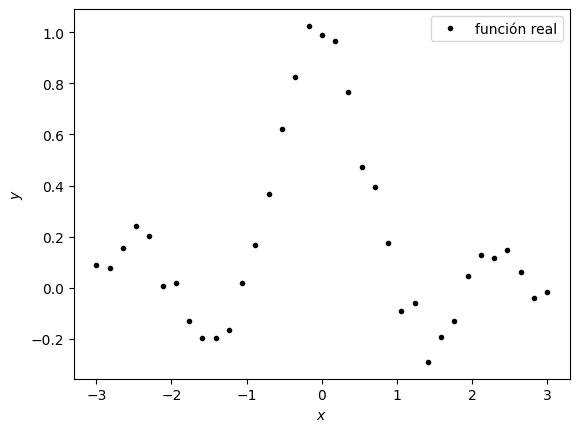

In [3]:
#plt.plot(Xtest, ytest)
plt.plot(Xtrain, ytrain, '.k')
plt.xlabel("$x$")
plt.ylabel("$y$");
plt.legend(['función real', 'observaciones ruidosas']);

Seguiremos usando el modelo de regresión con características polinomiales, es decir:

# Características polinomiales

Si asumimos $D=1$, entonces $\textbf x = x$. Además, $\phi_k(x) = x^k$ Por lo tanto, un polinomio de grado $K$ estaría definido como

$$
\begin{align}
f(x, \boldsymbol \theta) &= \sum_{k=0}^K \theta_k x^k, \\
%
&= \boldsymbol \phi(x)^\top\boldsymbol\theta,
\end{align}
$$

donde

$$
 \boldsymbol\phi(x)
 =
 \begin{bmatrix}
 \phi_0(x)\\
 \phi_1(x)\\
 \vdots\\
 \phi_K(x)
 \end{bmatrix}
 =
 \begin{bmatrix}
 x^0\\
 x^1\\
 \vdots\\
 x^K
 \end{bmatrix}
 \in \mathbb R^{K+1}.
$$

Es decir, $\boldsymbol\phi(x)$ es un vector que contiene todas transformaciones no lineales aplicadas sobre la entrada $x$. Agrupando para todos los datos $N$ se obtiene la matriz

$$
\boldsymbol\Phi =
\begin{bmatrix}
\boldsymbol\phi(x_1)^\top & \boldsymbol\phi(x_2)^\top & \cdots & \boldsymbol\phi(x_N)^\top
\end{bmatrix}
\in \mathbb R^{N \times (K+1)}.
$$

Por lo tanto,

$$
\textbf{y} = \boldsymbol \Phi \boldsymbol \theta
$$

In [4]:
def poli_carac(X, K):
    # Extraer caracteristicas polinomiales
    # X: N x D, vector de entradas
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi

    X = X.flatten()
    N = X.shape[0]

    #inicializar Phi
    Phi = np.zeros((N, K+1))

    # Calcular matriz Phi
    for k in range(K+1):
        Phi[:,k] = X**k
    return Phi

In [5]:
def plot_prediccion(X, prediccion):
  # Gráfica predicción
  plt.plot(X, np.sinc(X), lw=2, label='función real')
  plt.plot(X, prediccion, '-', lw=2, label='predicción')
  plt.plot(Xtrain, ytrain, '.k', label='datos entre.')
  # plt.xlabel("$x$")
  # plt.ylabel("$y$")
  plt.legend()
  plt.ylim([-0.3, 1.1])

# Máxima verosimilitud

### Inferencia usando extracción de caracteristicas

Si utilizamos funciones base (carácteristicas) los parámetros óptimos se calculan con la siguiente expresión

$$
\boldsymbol \theta^\text{MV} = (\boldsymbol\Phi^\top\boldsymbol\Phi)^{-1}\boldsymbol\Phi^\top \textbf{y}
$$

> Por motivos de estabilidad, es una práctica común adicionar un valor pequeño llamado "jitter" $\kappa>0$ en la diagonal de $\boldsymbol\Phi^\top\boldsymbol\Phi$, de manera que podamos invertir esta matriz sin problemas. Los parámetros óptimos se calculan entonces con la expresión

$$
\boldsymbol \theta^\text{MV} = (\boldsymbol\Phi^\top\boldsymbol\Phi + \kappa\textbf{I})^{-1}\boldsymbol\Phi^\top \textbf{y}
$$

In [6]:
def inferencia_max_vero_carac(Phi, y):
    # máxima verosimilitud usando caracteristicas
    # Phi: N x D, caracteristicas
    # y: N x 1, datos de salida observados
    # return: D x 1, vector de parametros estimados

    kappa = 1e-09 # jitter
    D = Phi.shape[1]

    Pt = Phi.T @ y # Phi^T*y
    PP = Phi.T @ Phi + kappa*np.eye(D) # Phi^T*Phi + kappa*I
    C = sp.linalg.cho_factor(PP)
    theta_ml = sp.linalg.cho_solve(C, Pt) # inv(Phi^T*Phi)*Phi^T*y
    #theta_ml = sp.linalg.solve(PP, Pt)
    return theta_ml

In [7]:
def rmse(y, y_pred):
  # Calculo función de error
  y = y.flatten()
  y_pred = y_pred.flatten()
  N = y.shape[0]
  difer = (y - y_pred)**2
  return np.sqrt((1.0/N) * np.sum(difer))

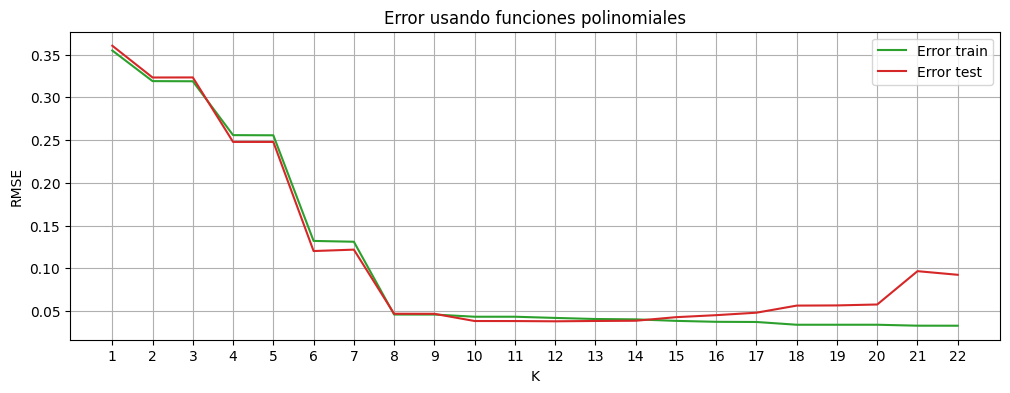

In [8]:
rmse_train = []
rmse_test = []
carac = poli_carac # seleccionar tipo de caracteristicas (poli, expo, cos)
K_max = 23 # cantidad máxima de caracteristicas


for i in range(1, K_max):
  # selección y parametrización
  K = i # grado del polinomio
  Phi = carac(Xtrain, K)

  # inferencia usando max vero
  theta_ml = inferencia_max_vero_carac(Phi, ytrain)

  # predicción sobre datos de entrenamiento
  Phi_test = carac(Xtrain, K)
  y_pred = Phi_test @ theta_ml # predicción
  rmse_train.append(rmse(ytrain, y_pred)) # medir error

  # predicción sobre datos de test
  Phi_test = carac(Xtest, K)
  y_pred = Phi_test @ theta_ml # predicción
  rmse_test.append(rmse(ytest, y_pred)) # medir error

# graficar errores
k_vector = np.linspace(1,K,K)

plt.figure(figsize=(12,4))
plt.plot(k_vector, rmse_train, 'C2-', label='Error train')
plt.plot(k_vector, rmse_test, 'C3-', label='Error test')
plt.xticks(k_vector);
plt.ylabel('RMSE')
plt.xlabel('K')
plt.title('Error usando funciones polinomiales')
plt.legend()
plt.grid()

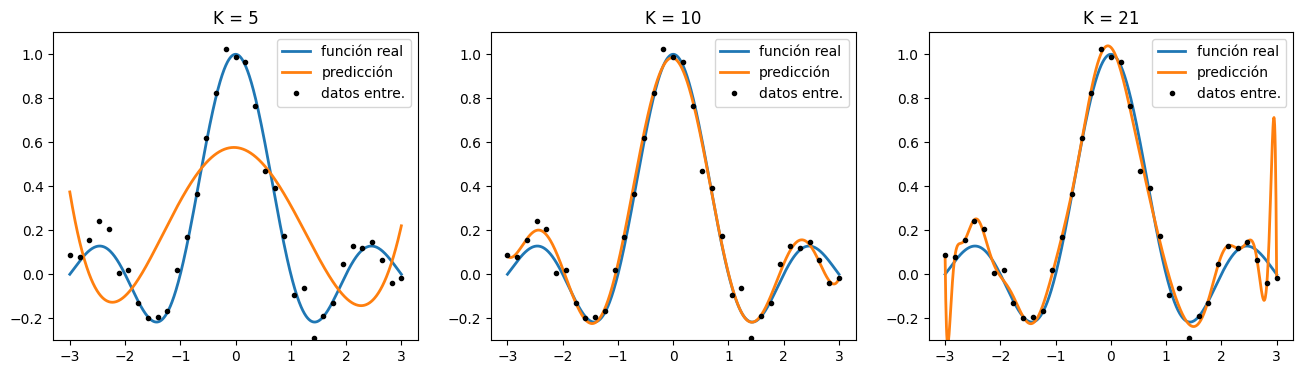

In [9]:
k_values = [5, 10, 21]
plt.figure(figsize=(16,4))
for i in range(3):
  K = k_values[i]
  Phi = poli_carac(Xtrain, K) # características datos entrenamiento
  theta_ml = inferencia_max_vero_carac(Phi, ytrain)

  Phi_test = poli_carac(Xtest, K) # características todos los datos
  y_pred = Phi_test @ theta_ml # predicción

  # graficar resultados
  plt.subplot(1,3,i+1)
  plot_prediccion(Xtest, y_pred)
  plt.title('K = ' + str(K));

$K = 4$ (underfitting) sub entrenamiento

$K = 10$ (best fit) generalización adecuada

$K = 19$ (overfitting) sobreentrenamiento


# Máximo a posteriori (MAP)
En vez de maximizar la verosimilitud de los datos, podemos maximizar la *distribución de probabilidad posterior* sobre los parámetros $\boldsymbol\theta$, la cual estaba por

$$
p(\boldsymbol\theta|\mathcal X, \mathcal Y) = \frac{\overbrace{p(\mathcal Y|\mathcal X, \boldsymbol\theta)}^{\text{likelihood}}\overbrace{p(\boldsymbol\theta)}^{\text{prior}}}{\underbrace{p(\mathcal Y|\mathcal X)}_{\text{evidence}}}
$$

El propósito del prior $p(\boldsymbol\theta)$ es reducir la tendencia a que los parámetros tengan valores muy grandes, lo cual es un indicio de sobreentrenamiento. Controlar los valores que toman los parámetros en el proceso de inferencia, con el propósito de generar mejores predicciones en los datos de Test, se conoce como **regularización**. Normalmente se escoge un prior Gaussiano $\mathcal N(\boldsymbol 0, \alpha^2\boldsymbol I)$ centrado en el origen con determinada varianza $\alpha^2$.

La estimación con MAP corresponde a

$$
\boldsymbol\theta^{\text{MAP}} = (\boldsymbol\Phi^T\boldsymbol\Phi + \frac{\sigma^2}{\alpha^2}\textbf{I})^{-1}\boldsymbol\Phi^T \textbf{y}
$$

donde $\sigma^2$ es la varianza del ruido.

In [10]:
## EDIT THIS FUNCTION
def inferencia_max_posterior_carac(Phi, y, sigma, alpha):
  # Phi: N x D, características de entrada
  # y: D x 1, datos de salida
  # sigma: escalar, desviación estandar del ruido
  # alpha: escalar, desviación estandar del prior sobre los parámetros
  # return: D x 1,  estimación MAP theta_map

  D = Phi.shape[1]

  # SOLUTION
  PP = Phi.T @ Phi + (sigma/alpha)**2 * np.eye(D)
  theta_map = sp.linalg.solve(PP, Phi.T @ y)

  return theta_map

In [11]:
# get the MAP estimate
K = 12 # polynomial degree

alpha = 0.25 # standard deviation of the parameter prior

# feature matrix
Phi = poli_carac(Xtrain, K)

theta_map = inferencia_max_posterior_carac(Phi, ytrain, sigma, alpha)

# maximum likelihood estimate
theta_ml = inferencia_max_vero_carac(Phi, ytrain)


Phi_test = poli_carac(Xtest, K)

y_pred_map = Phi_test @ theta_map
y_pred_mv = Phi_test @ theta_ml

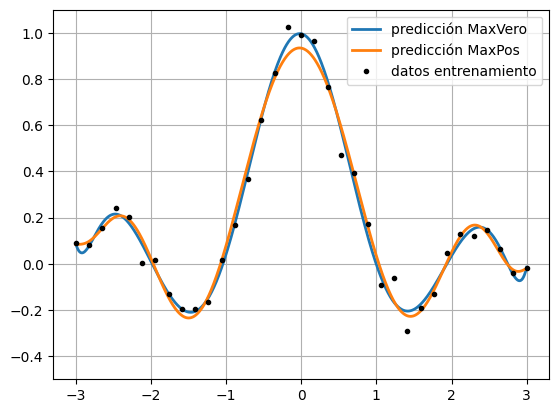

In [12]:
plt.plot(Xtest, y_pred_mv, lw=2)
plt.plot(Xtest, y_pred_map, lw=2)
plt.plot(Xtrain, ytrain, '.k')
plt.legend(["predicción MaxVero", "predicción MaxPos", "datos entrenamiento"]);
plt.ylim([-0.5, 1.1])
plt.grid()

[[ 9.95693472e-01  9.33702506e-01]
 [-6.33750197e-02 -5.68214659e-02]
 [-1.58779102e+00 -1.23089197e+00]
 [ 5.11476220e-02  3.92738299e-02]
 [ 7.66680781e-01  3.66860325e-01]
 [-1.02937392e-02 -3.66482464e-03]
 [-1.77266429e-01 -2.98082961e-03]
 [ 2.30702233e-04 -1.34357584e-03]
 [ 2.37900342e-02 -1.16023124e-02]
 [ 7.25384804e-05  2.39610098e-04]
 [-1.84765062e-03  1.52026981e-03]
 [-3.79903096e-06 -1.03228161e-05]
 [ 6.29843020e-05 -5.83587656e-05]]


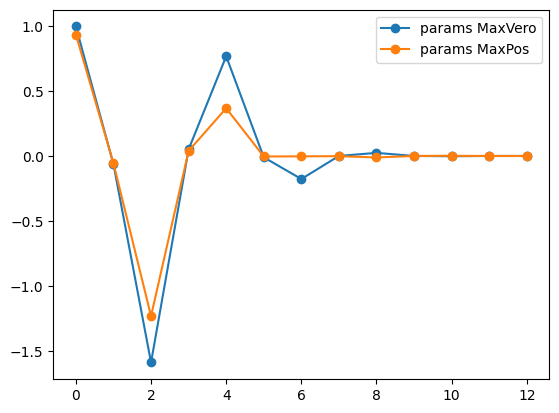

In [13]:
plt.plot(theta_ml, '-o', label='params MaxVero')
plt.plot(theta_map, '-o', label='params MaxPos')
plt.legend()
print(np.hstack([theta_ml, theta_map]))

Ahora, calculemos el error RMSE para diferentes valores de $K$, y observemos si la estimación MAP reduce el sobreentrenamiento que presenta la inferencia por máxima verosimilitud.



<ipython-input-10-3cd91965c636>:13: LinAlgWarning: Ill-conditioned matrix (rcond=6.95453e-17): result may not be accurate.
  theta_map = sp.linalg.solve(PP, Phi.T @ y)
<ipython-input-10-3cd91965c636>:13: LinAlgWarning: Ill-conditioned matrix (rcond=6.95861e-18): result may not be accurate.
  theta_map = sp.linalg.solve(PP, Phi.T @ y)
<ipython-input-10-3cd91965c636>:13: LinAlgWarning: Ill-conditioned matrix (rcond=7.13904e-19): result may not be accurate.
  theta_map = sp.linalg.solve(PP, Phi.T @ y)
<ipython-input-10-3cd91965c636>:13: LinAlgWarning: Ill-conditioned matrix (rcond=8.12575e-20): result may not be accurate.
  theta_map = sp.linalg.solve(PP, Phi.T @ y)
<ipython-input-10-3cd91965c636>:13: LinAlgWarning: Ill-conditioned matrix (rcond=9.15837e-21): result may not be accurate.
  theta_map = sp.linalg.solve(PP, Phi.T @ y)
<ipython-input-10-3cd91965c636>:13: LinAlgWarning: Ill-conditioned matrix (rcond=9.89566e-22): result may not be accurate.
  theta_map = sp.linalg.solve(PP, Phi

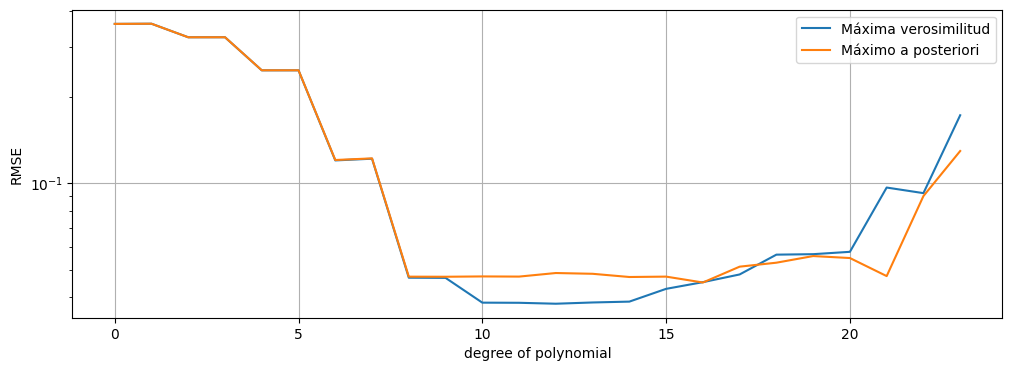

In [14]:
## EDIT THIS CELL

K_max = 23 # this is the maximum degree of polynomial we will consider

rmse_mle = np.zeros((K_max+1,))
rmse_map = np.zeros((K_max+1,))

for k in range(K_max+1):

    # feature matrix
    Phi = poli_carac(Xtrain, k)

    # maximum likelihood estimate
    theta_ml = inferencia_max_vero_carac(Phi, ytrain)

    # predict the function values at the test input locations (maximum likelihood)

    ####################### SOLUTION
    # feature matrix for test inputs
    Phi_test = poli_carac(Xtest, k)

    # prediction
    ypred_test_mle = Phi_test @ theta_ml
    #######################

    # RMSE on test set (maximum likelihood)
    rmse_mle[k] = rmse(ytest, ypred_test_mle)

    # MAP estimate
    theta_map = inferencia_max_posterior_carac(Phi, ytrain, sigma, alpha)

    # Feature matrix
    Phi_test = poli_carac(Xtest, k)

    # predict the function values at the test input locations (MAP)
    ypred_test_map = Phi_test @ theta_map

    # RMSE on test set (MAP)
    rmse_map[k] = rmse(ytest, ypred_test_map)


plt.figure(figsize=(12,4))
plt.semilogy(rmse_mle) # this plots the RMSE on a logarithmic scale
plt.semilogy(rmse_map) # this plots the RMSE on a logarithmic scale
plt.xlabel("degree of polynomial")
plt.ylabel("RMSE")
plt.legend(["Máxima verosimilitud", "Máximo a posteriori"])
plt.grid()

> **Ejercicio 1:**
  Describa qué observa en estas gráficas?

**Respuesta:**


> **Ejercicio 2:** Cómo afecta la varianza del prior ($\alpha^2$) a las predicciones y parámetros inferidos? Cambie el valor de la varianza $\alpha^2$ y describa qué ocurre.

**Respuesta:**

# Regresión lineal Bayesiana

En regresión lineal se considera el siguiente modelo, definiendo el prior sobre los parámetros y la verosimilitud:

$$p(\boldsymbol \theta) = \mathcal{N}(\textbf{m}_0, \textbf{S}_0),$$

$$p(y|x, \boldsymbol{\theta}) = \mathcal{N}(y|\boldsymbol{\phi}^{\top}(x)\boldsymbol{\theta}, \sigma^2),$$

El posterior sobre los parámetros corresponde a
$$
p(\boldsymbol\theta|\mathcal X, \mathcal Y) = \frac{\overbrace{p(\mathcal Y|\mathcal X, \boldsymbol\theta)}^{\text{likelihood}}\overbrace{p(\boldsymbol\theta)}^{\text{prior}}}{\underbrace{p(\mathcal Y|\mathcal X)}_{\text{evidence}}}
$$,

es decir
$$
p(\boldsymbol\theta|\mathcal X, \mathcal Y) = \mathcal{N}(\textbf{m}_N, \textbf{S}_N),
$$

con

$$
\textbf{S}_N = (\textbf{S}_0^{-1} + \sigma^{-2} \boldsymbol{\Phi}^{\top}\boldsymbol{\Phi})^{-1},
$$

y

$$
\textbf{m}_N =
\textbf{S}_N(\textbf{S}_0^{-1}\textbf{m}_0 + \sigma^{-2} \boldsymbol{\Phi}^{\top}\textbf{y}).
$$


In [15]:
prior_var = 1.0 # variance of the parameter prior (alpha^2). We assume this is known.
noise_var = sigma**2 # noise variance (sigma^2). We assume this is known.

pol_deg = 10 # degree of the polynomial we consider at the moment

Asumiendo un prior sobre los parámetros de la forma

$$p(\boldsymbol\theta) = \mathcal N (\boldsymbol 0, \alpha^2\boldsymbol I)$$,

para cada dato de test $\boldsymbol x_*$ se obtiene la siguiente media predictiva

$$
E[f(\boldsymbol x_*)] = 0.
$$

Asimismo, la varianza predictiva inicial corresponde a (ignorando la varianza del ruido)

$$
V[f(\boldsymbol x_*)] = \alpha^2\boldsymbol\phi(\boldsymbol x_*) \boldsymbol\phi(\boldsymbol x_*)^\top
$$

donde $\boldsymbol\phi(\cdot)$ son las características o funciones base escogidas, para este caso funciones polinomiales.

In [16]:
def plot_distribution(x, media, var):
  # graficar media e intervalo de confianza

  x = x.flatten()
  media = media.flatten()
  var = var.flatten()
  conf = 2.0*np.sqrt(var) # intervalo de confianza

  plt.figure()
  plt.plot(x, media, color="C0")
  plt.fill_between(x, media + conf, media - conf, alpha = 0.1, color="C0")
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.title("distribución de probabilidad");

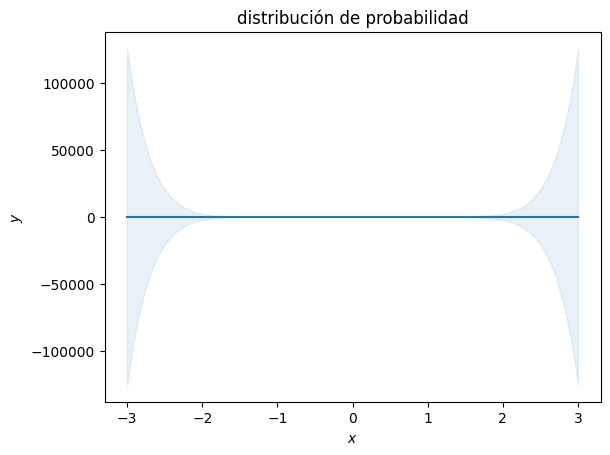

In [17]:
# compute the feature matrix for the test inputs
Phi_test = poli_carac(Xtest, pol_deg) # N x (pol_deg+1) feature matrix SOLUTION

# compute the (marginal) prior at the test input locations
# prior mean
prior_mean = np.zeros((Ntest,1)) # prior mean <-- SOLUTION

# prior variance
full_covariance = Phi_test @ Phi_test.T * prior_var # N x N covariance matrix of all function values
prior_marginal_var =  np.diag(full_covariance)

plot_distribution(Xtest, prior_mean, prior_marginal_var)

Esta distribución inicial la podemos utilizar para muestrear "funciones solución" del problema de regresión.

Every sampled function is a polynomial of degree 10


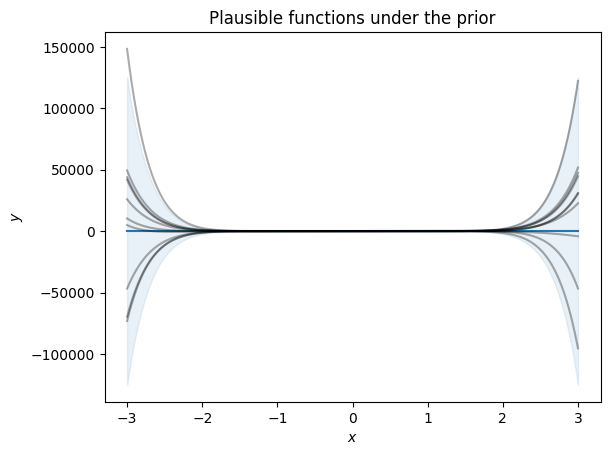

In [18]:
## EDIT THIS CELL

# samples from the prior
num_samples = 10

# We first need to generate random weights theta_i, which we sample from the parameter prior
random_weights = np.random.normal(size=(pol_deg+1,num_samples),
                                  scale=np.sqrt(prior_var))

# Now, we compute the induced random functions, evaluated at the test input locations
# Every function sample is given as f_i = Phi * theta_i,
# where theta_i is a sample from the parameter prior

sample_function = Phi_test @ random_weights # <-- SOLUTION

plot_distribution(Xtest, prior_mean, prior_marginal_var)
plt.plot(Xtest, sample_function, color="k", alpha=0.33)
plt.title("Plausible functions under the prior")
print("Every sampled function is a polynomial of degree "+str(pol_deg));


Una vez establecido el modelo podemos unificarlo con la base de datos que tengamos a disposición, y calcular la distribución posterior sobre el modelo $f$

$$
\boldsymbol x_1, \dotsc, \boldsymbol x_N
$$,

$$
\boldsymbol X = [\boldsymbol x_1, \dotsc, \boldsymbol x_N]^\top\in\mathbb{R}^{N\times D}
$$.

Now, let us compute the posterior

In [19]:
## EDIT THIS FUNCTION

def polyfit(X, y, K, prior_var, noise_var):
    # X: training inputs, size N x D
    # y: training targets, size N x 1
    # K: degree of polynomial we consider
    # prior_var: prior variance of the parameter distribution
    # sigma: noise variance

    jitter = 1e-08 # increases numerical stability

    Phi = poli_carac(X, K) # N x (K+1) feature matrix

    # Compute maximum likelihood estimate
    Pt = Phi.T @ y # Phi*y, size (K+1,1)
    PP = Phi.T @ Phi + jitter*np.eye(K+1) # size (K+1, K+1)
    C = sp.linalg.cho_factor(PP)
    # maximum likelihood estimate
    theta_ml = sp.linalg.cho_solve(C, Pt) # inv(Phi^T*Phi)*Phi^T*y, size (K+1,1)

#     theta_ml = scipy.linalg.solve(PP, Pt) # inv(Phi^T*Phi)*Phi^T*y, size (K+1,1)

    # MAP estimate
    theta_map = sp.linalg.solve(PP + noise_var/prior_var*np.eye(K+1), Pt)

    # parameter posterior
    iSN = (np.eye(K+1)/prior_var + PP/noise_var) # posterior precision
    SN = sp.linalg.pinv(noise_var*np.eye(K+1)/prior_var + PP)*noise_var  # posterior covariance
    mN = sp.linalg.solve(iSN, Pt/noise_var) # posterior mean

    return (theta_ml, theta_map, mN, SN)

In [20]:
theta_ml, theta_map, theta_mean, theta_var = polyfit(Xtrain, ytrain, pol_deg, alpha, sigma)

En el caso de regesión lineal Bayesiana, la predicción que obtenemos es una distribución de probabilidad posterior sobre la función $f$ con la que queremos modelar los datos observados, es decir

$$
p(y_*| \mathcal{X},\mathcal{Y}, x_*) =
\mathcal{N}(y_*| \hat{m}, \hat{\sigma}^2 ),
$$

donde

$$
\hat{m} = \boldsymbol{\phi}(x_*)^{\top}\textbf{m}_N,
$$

y

$$
\hat{\sigma}^2 = \boldsymbol{\phi}(x_*)^{\top}\textbf{S}_N\boldsymbol{\phi}(x_*) + \sigma^2.
$$


Una vez entrenado el modelo podemos hacer predicciones usando el modelo de regresión lineal Bayesiana. Recapitulando, hemos aprendido a implementar tres tipos de predictores:

\begin{align}
&\text{Maximum likelihood: }E[f(\boldsymbol X_{\text{test}})] = \boldsymbol \phi(X_{\text{test}})\boldsymbol \theta_{ml}\\
&\text{Maximum a posteriori: } E[f(\boldsymbol X_{\text{test}})] = \boldsymbol \phi(X_{\text{test}})\boldsymbol \theta_{map}\\
&\text{Bayesian: } p(f(\boldsymbol X_{\text{test}})) = \mathcal N(f(\boldsymbol X_{\text{test}}) \,|\, \boldsymbol \phi(X_{\text{test}}) \boldsymbol\theta_{\text{mean}},\, \boldsymbol\phi(X_{\text{test}}) \boldsymbol\theta_{\text{var}}  \boldsymbol\phi(X_{\text{test}})^\top)
\end{align}

In [21]:
## EDIT THIS CELL

# predictions (ignoring the measurement/observations noise)

Phi_test = poli_carac(Xtest, pol_deg) # N x (K+1)

# maximum likelihood predictions (just the mean)
m_mle_test = Phi_test @ theta_ml

# MAP predictions (just the mean)
m_map_test = Phi_test @ theta_map

# predictive distribution (Bayesian linear regression)
# mean prediction
mean_blr = Phi_test @ theta_mean
# variance prediction
cov_blr =  Phi_test @ theta_var @ Phi_test.T

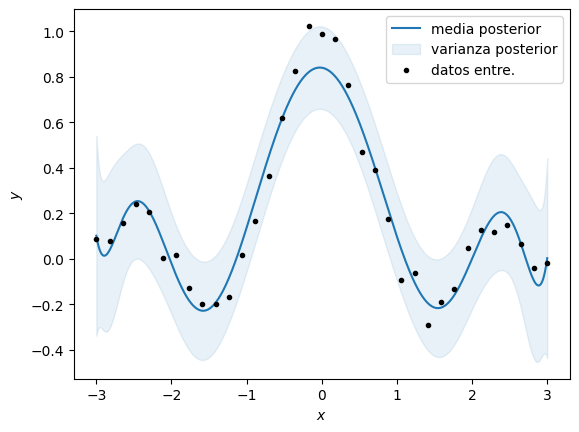

In [22]:
# plot the posterior
plt.figure()
#plt.plot(Xtest, m_mle_test)
plt.plot(Xtest, m_map_test, 'C0')
var_blr = np.diag(cov_blr)
# conf_bound1 = np.sqrt(var_blr).flatten()
conf_bound2 = 2.0*np.sqrt(var_blr).flatten()
# conf_bound3 = 2.0*np.sqrt(var_blr + sigma).flatten()

# plt.fill_between(Xtest.flatten(), mean_blr.flatten() + conf_bound1,
                #  mean_blr.flatten() - conf_bound1, alpha = 0.1, color="k")
plt.fill_between(Xtest.flatten(), mean_blr.flatten() + conf_bound2,
                 mean_blr.flatten() - conf_bound2, alpha = 0.1, color="C0")
# plt.fill_between(Xtest.flatten(), mean_blr.flatten() + conf_bound3,
                #  mean_blr.flatten() - conf_bound3, alpha = 0.1, color="k")
plt.plot(Xtrain, ytrain, ".k")
plt.legend(["media posterior", "varianza posterior", "datos entre."])
plt.xlabel('$x$');
plt.ylabel('$y$');

# Trabajo de laboratorio
Como trabajo de laboratorio vamos a entrenar un modelo de regresión para el caso **univariado** $y_n = f(x_n) + \epsilon$. Llevar a cabo el siguiente procedimiento:

1. Descargar la base de datos ```EET-small``` y visualizar la variable a predecir ```oil temperature``` (https://github.com/zhouhaoyi/ETDataset).

In [54]:
import numpy as np
import scipy as sp
import sklearn as skl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from ipywidgets import interact

In [24]:
!wget "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv" -O "ETTh1.csv"
!wget "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh2.csv" -O "ETTh2.csv"
!wget "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm1.csv" -O "ETTm1.csv"
!wget "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm2.csv" -O "ETTm2.csv"

--2023-11-03 23:54:00--  https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2589657 (2.5M) [text/plain]
Saving to: ‘ETTh1.csv’

ETTh1.csv           100%[===================>]   2.47M  --.-KB/s    in 0.08s   

2023-11-03 23:54:01 (31.9 MB/s) - ‘ETTh1.csv’ saved [2589657/2589657]

--2023-11-03 23:54:01--  https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2417960 (2.3M) [text/plain]


In [25]:
dataset = pd.read_csv("ETTm1.csv", sep = ",")
dataset[:20]

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
5,2016-07-01 01:15:00,5.492,1.942,1.457,0.391,4.112,1.279,27.716999
6,2016-07-01 01:30:00,5.358,1.875,1.350,0.355,3.929,1.340,27.646000
7,2016-07-01 01:45:00,5.157,1.808,1.350,0.320,3.807,1.279,27.084000
8,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
9,2016-07-01 02:15:00,5.157,1.808,1.350,0.426,3.777,1.188,27.506001


In [69]:
y = pd.read_csv("ETTm1.csv", sep = ",")['OT'] # se lee el archivo csv y se extrae solo la columna 'OT'
y = y.values.reshape(-1,1)

escala = MinMaxScaler()
escala.fit(y)

Y = escala.fit_transform(y)

# Imprimir la longitud del array 'y', que es el número de elementos en la columna 'OT'
print(len(y))

# Crear un array 'X' con valores
X = np.arange(0, len(y))

69680


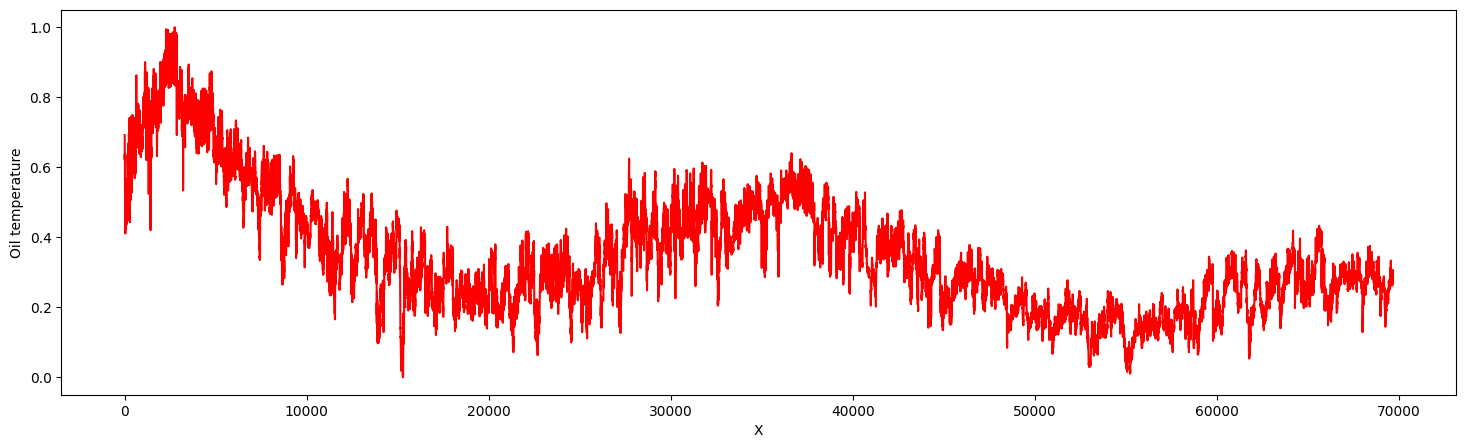

In [36]:
plt.figure(figsize=(18,5))
plt.plot(x,y, 'r') # Grafica
plt.xlabel("X")
plt.ylabel("Oil temperature")
plt.show()

2. Dividir la base de datos en 70% entrenamiento y 30% test, utilizando una partición aleatoria.

In [70]:
# Calcular el 70% de la longitud del array 'X' para saber cuántos datos se utilizarán para el entrenamiento
print(len(X)*0.7)

# Desordenar los datos de 'X' y 'Y' de manera sincronizada para deshacer cualquier orden preexistente
Xs, ys = skl.utils.shuffle(X, Y)

# Determinar el punto de corte para el 70% de los datos para el entrenamiento
Xtrain = Xs[0:48776] # 70% entrenamiento
ytrain = ys[0:48776]

# Determinar el punto de corte para el 30% de los datos para el entrenamiento
Xtest = Xs[48776:] # 30% test
ytest= ys[48776:]

48776.0


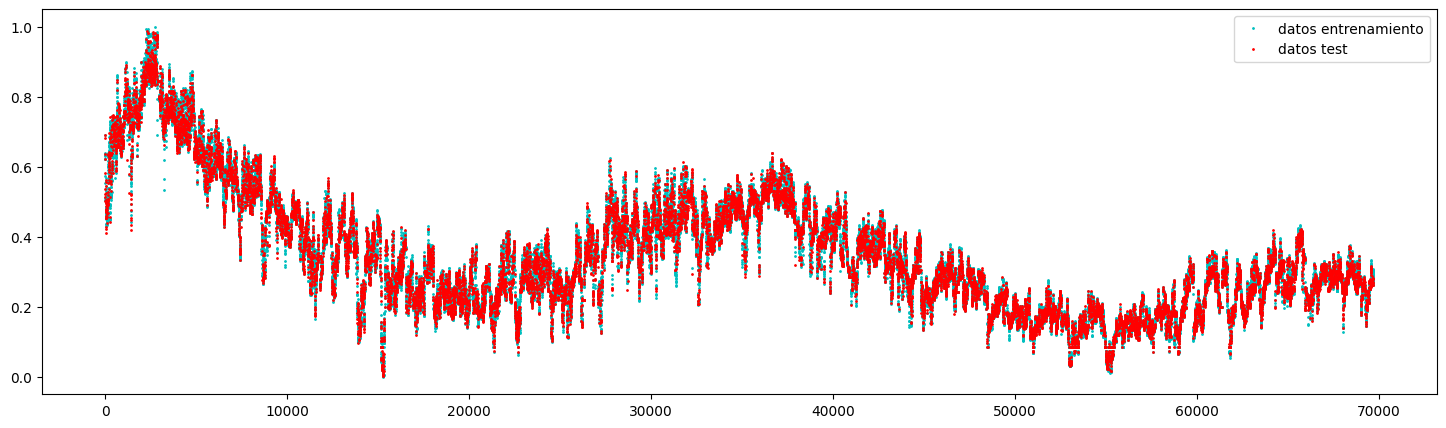

In [75]:
plt.figure(figsize=(18, 5))
plt.plot(Xtrain, ytrain, '.c',markersize=2)
plt.plot(Xtest, ytest, '.r',markersize=2)
plt.legend(['datos entrenamiento', 'datos test'])

3. Utilice las funciones exponenciales cuadráticas como funciones base, y estime los parámetros del modelo utilizando MAP para diez valores diferentes de $M$ (número de funciónes base).

In [76]:
def expo_carac(X, K):
    # Extraer caracteristicas exponenciales
    # X: N x D, vector de entradas
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi

    X = X.flatten()
    N = X.shape[0]

    #inicializar Phi
    Phi = np.ones((N, K+1))
    mu = np.linspace(0,69680,K)
    sig2 = 10

    # Calcular matriz Phi
    for k in range(1, K+1):
        Phi[:,k] = np.exp(-(mu[k-1] - X)**2/sig2)
    return Phi

In [77]:
def inferencia_max_posterior_carac(Phi, y, sigma, alpha):
  # Phi: N x D, características de entrada
  # y: D x 1, datos de salida
  # sigma: escalar, desviación estandar del ruido
  # alpha: escalar, desviación estandar del prior sobre los parámetros
  # return: D x 1,  estimación MAP theta_map

  D = Phi.shape[1]

  # SOLUTION
  PP = Phi.T @ Phi + (sigma/alpha)**2 * np.eye(D)
  theta_map = sp.linalg.solve(PP, Phi.T @ y)

  return theta_map

In [78]:
def cal_mu(m): #FUNCIÓN PARA CALCULAR LA MATRIZ DE MEDIAS
  #Se definen vectores que recorran el dominio de cada variable
  #Se revuelven aleatoriamente y luego se concatenan para asi tener una matriz de medias a lo largo de todo el dominio
  mu_x = np.linspace(x.min(),x.max(),m).reshape(-1,1)

  mu_x = skl.utils.shuffle(mu_x, random_state=0)
  return mu_x

In [80]:
@interact(K = (1,250,1), sigma=(0.001,1,0.01), alpha = (0.001,1,0.01))

# get the MAP estimate
def MAP_estimate(K,sigma,alpha):
  #K = 50
  #sigma = 0.05
  #alpha = 0.25 # standard deviation of the parameter prior

  # feature matrix
  Phi = expo_carac(Xtrain, K)

  theta_map = inferencia_max_posterior_carac(Phi, ytrain, sigma, alpha)
  Phi_test = expo_carac(X, K)
  Phi_train = expo_carac(Xtrain, K)
  y_pred_map = Phi_test @ theta_map

  plt.figure(figsize=(18, 5))
  plt.plot(X, Y)
  plt.plot(X, y_pred_map, '--', lw=2)
  plt.legend([ "funcion real","predicción"]);
  plt.title('K = ' + str(K))
  plt.grid()
  plt.show()

interactive(children=(IntSlider(value=125, description='K', max=250, min=1), FloatSlider(value=0.491, descript…

In [81]:
theta_map

array([[ 0.34968562],
       [ 0.32848284],
       [ 0.17591477],
       [ 0.6861857 ],
       [ 0.43869731],
       [ 0.18751427],
       [ 0.24071779],
       [ 0.23528661],
       [ 0.12114005],
       [-0.03340287],
       [ 0.01050929],
       [-0.2260116 ],
       [-0.11949694],
       [-0.12118912],
       [-0.0626425 ],
       [-0.20146278],
       [-0.25772442],
       [-0.16812323],
       [ 0.01740948],
       [-0.19043382],
       [ 0.01712133],
       [ 0.04402591],
       [ 0.05960014],
       [ 0.11245312],
       [ 0.0180023 ],
       [ 0.1339222 ],
       [ 0.18816656],
       [ 0.12075585],
       [ 0.13679622],
       [ 0.03895585],
       [-0.08858539],
       [ 0.04817047],
       [-0.06934634],
       [-0.13131987],
       [-0.0376767 ],
       [-0.1286905 ],
       [-0.24303095],
       [-0.21761781],
       [-0.19353555],
       [-0.15709648],
       [-0.28626211],
       [-0.16816199],
       [-0.25905635],
       [-0.08311177],
       [-0.14814237],
       [-0

In [82]:
X.shape

(69680,)

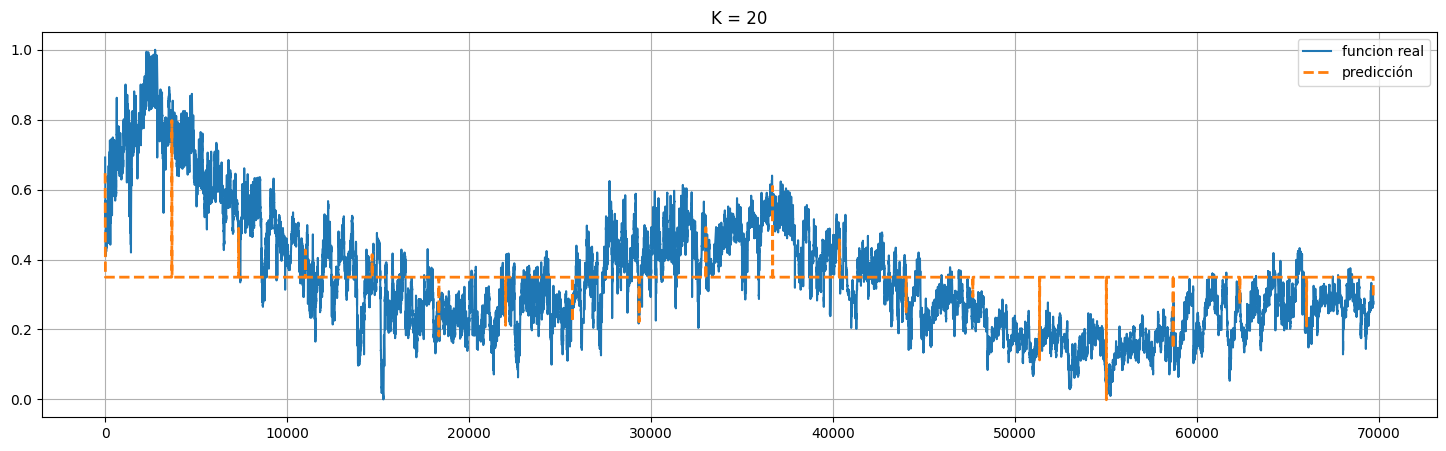

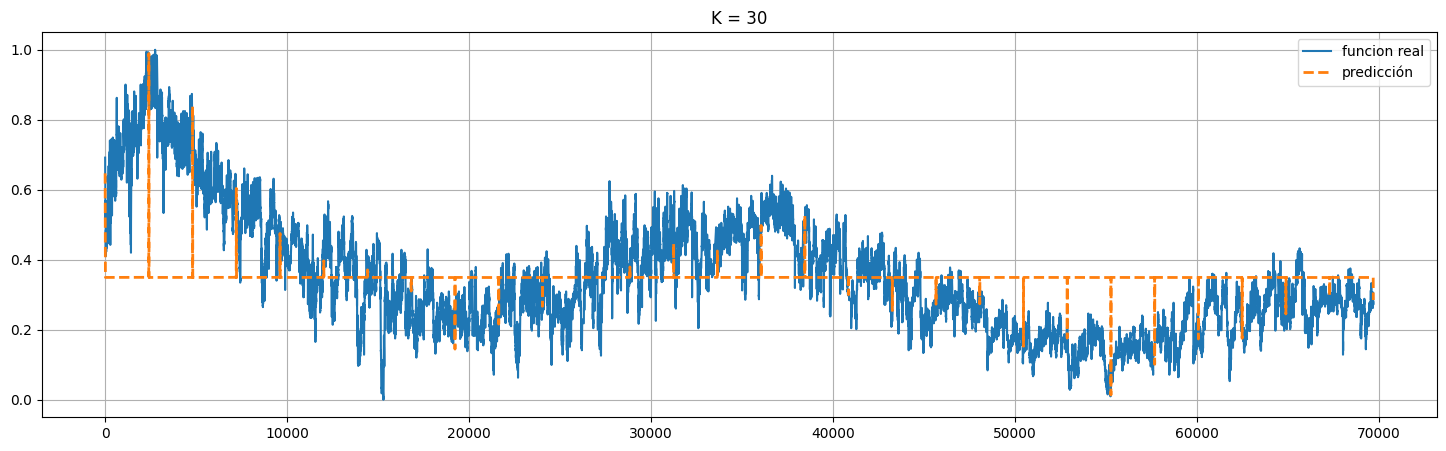

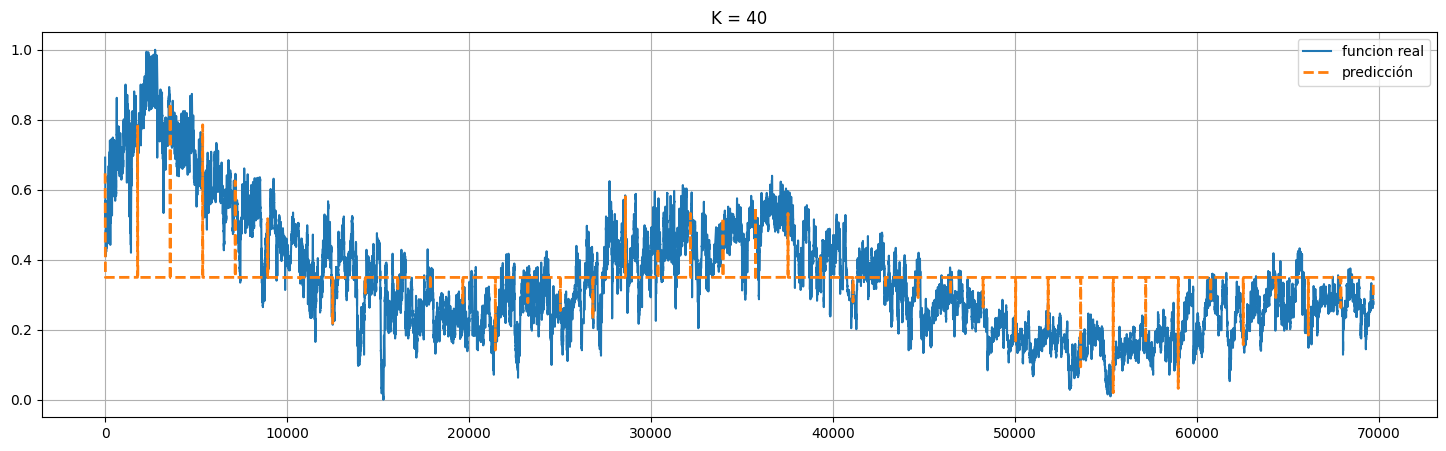

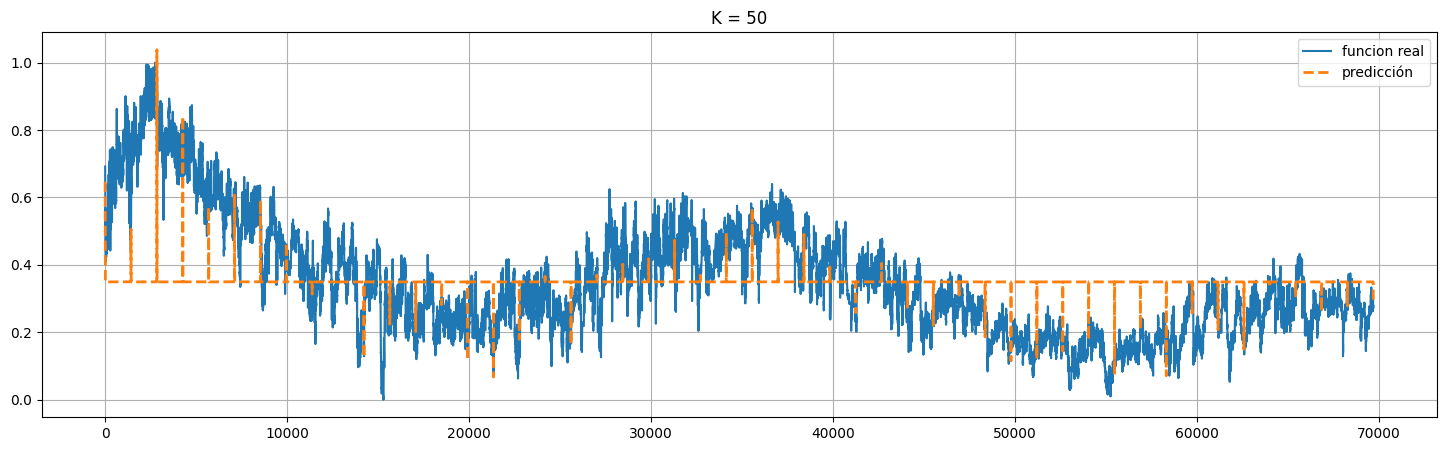

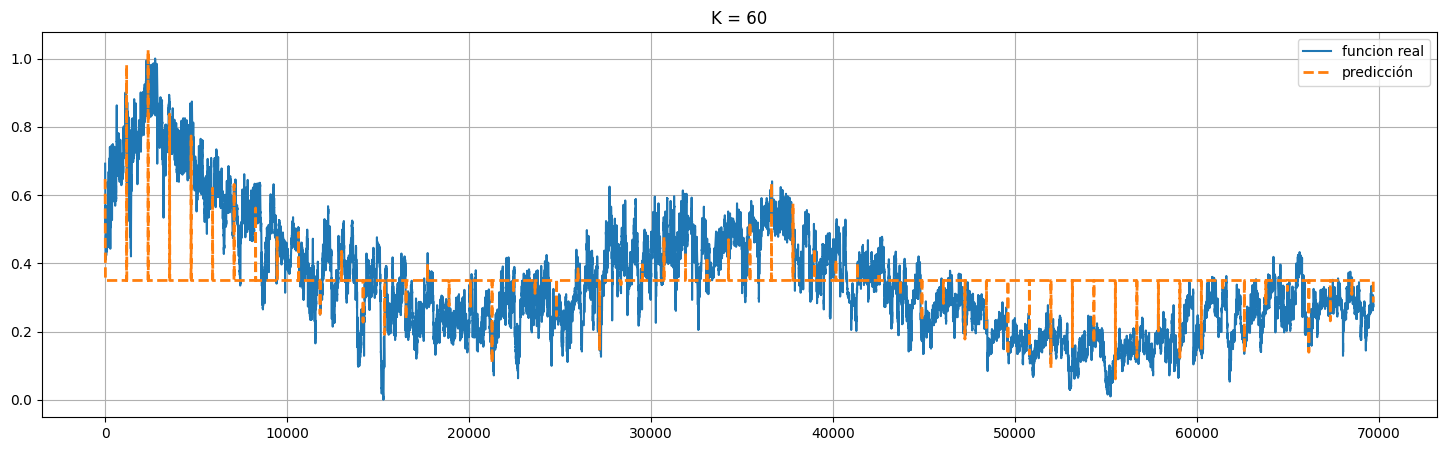

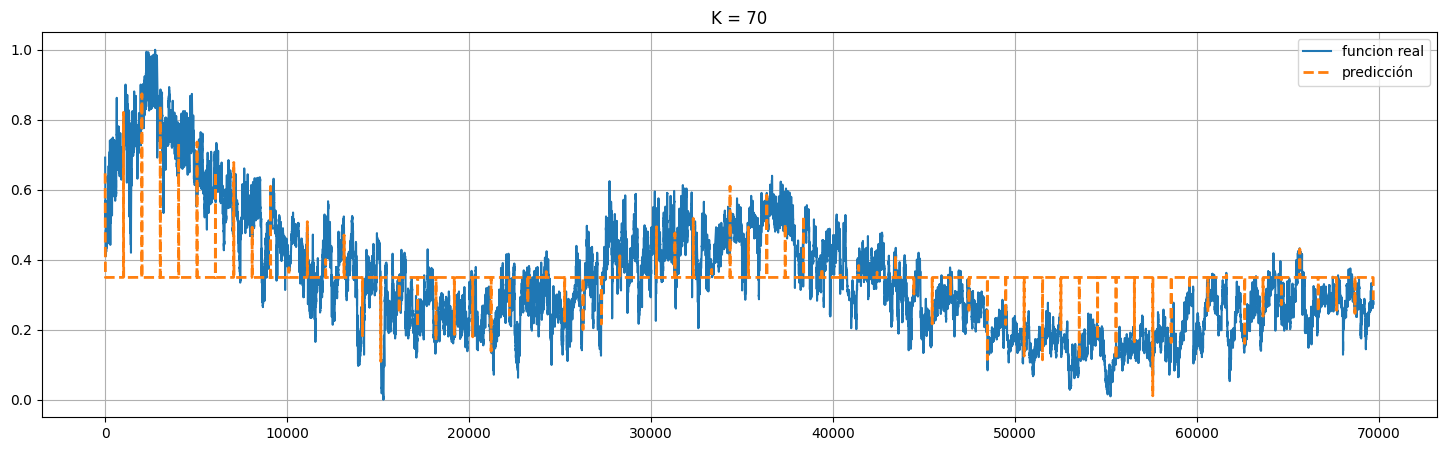

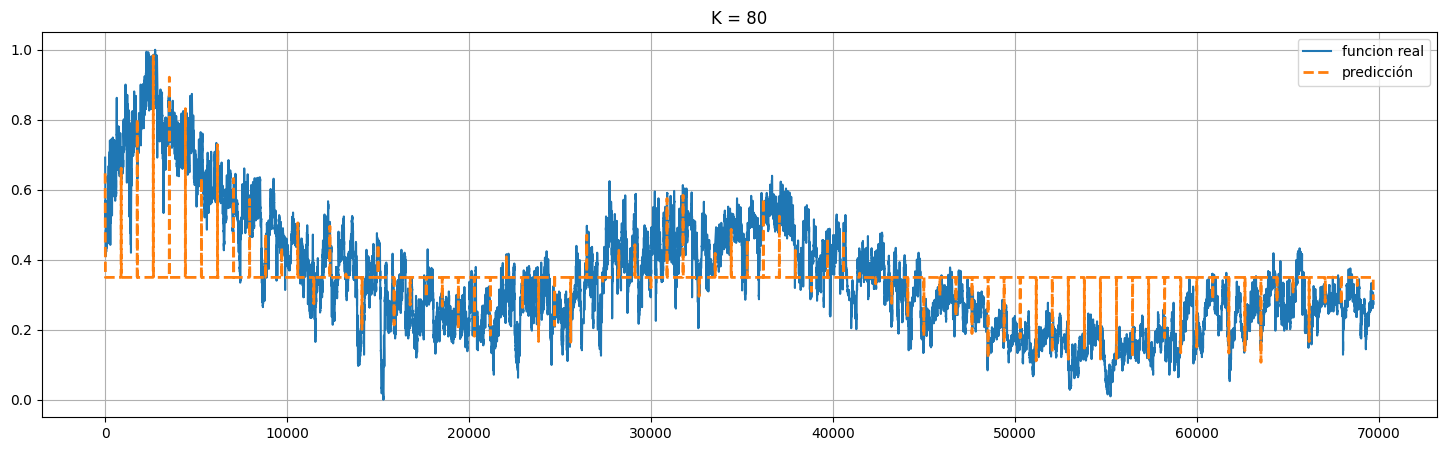

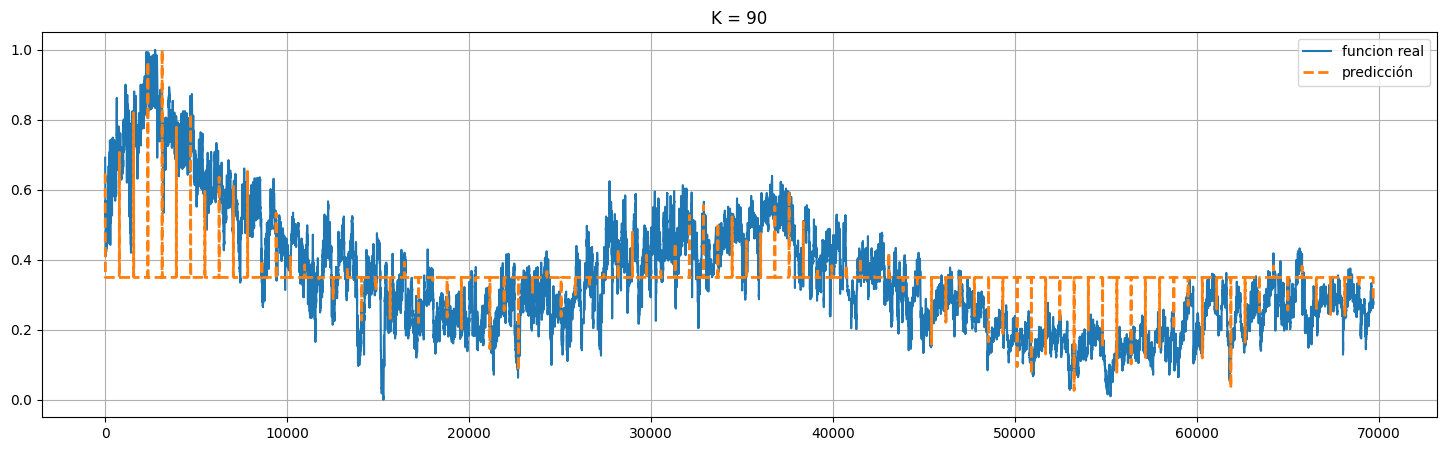

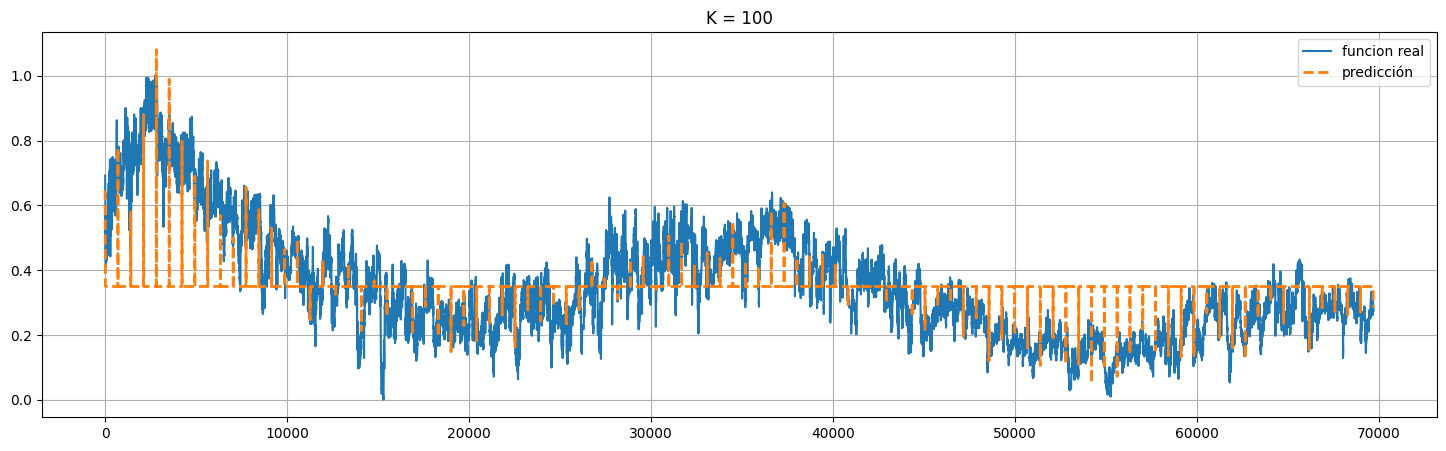

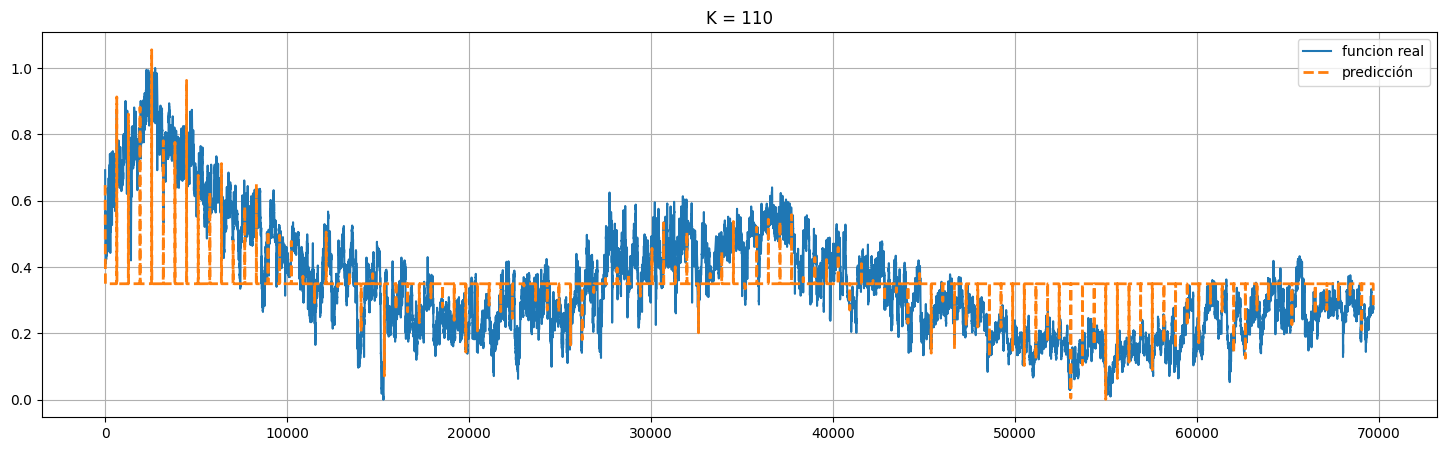

In [84]:
# Definición de los parámetros sigma y alpha
sigma=0.35
alpha=0.48

# Bucle para iterar sobre un rango de valores para k
for k in range(20,120,10):
  MAP_estimate(k,sigma,alpha)

4. Calcule el MSE entre:

  - la predicción de los modelos y los datos de entrenamiento,
  - la predicción de los modelos y los datos de test.

In [87]:
from sklearn.metrics import mean_squared_error

K=10

# Transformar los datos de entrenamiento y de prueba
Phi_train = expo_carac(Xtrain, K)
Phi_test = expo_carac(Xtest, K)

# Realizar la inferencia MAP
theta_map_train = inferencia_max_posterior_carac(Phi_train, ytrain, sigma, alpha)
theta_map_test = inferencia_max_posterior_carac(Phi_test, ytest, sigma, alpha)

# Realizar predicciones multiplicando las características transformadas 'Phi_test' con la estimación MAP de parámetros 'theta_map_test'
y_map_test = Phi_test @ theta_map_test
y_map_train = Phi_train @ theta_map_train

In [88]:
print('MSE con datos entrenamiento: ', mean_squared_error(Xtrain, y_map_train))
print('MSE con datos de test: ', mean_squared_error(Xtest, y_map_test))

MSE con datos entrenamiento:  1612118549.3374386
MSE con datos de test:  1632973262.153981


In [90]:
def rmse(y, y_pred):
  # Calculo función de error
  y = y.flatten()
  y_pred = y_pred.flatten()
  N = y.shape[0]
  difer = (y - y_pred)**2

  return np.sqrt((1.0/N) * np.sum(difer))

In [62]:
def rmse_k(carac,K_max,titulo):

  rmse_train = []
  rmse_test = []
  K_vector = []
  #carac = expo_carac # seleccionar tipo de caracteristicas (poli, expo, cos)
  #K_max = 200 # cantidad máxima de caracteristicas
  sigma=0.35
  alpha=0.48
  for i in range(1, K_max,1):
    K = i
    Phi_train = carac(Xtrain, K)
    theta_ml = inferencia_max_posterior_carac(Phi_train, ytrain, sigma, alpha)

    y_pred = Phi_train @ theta_ml # predicción
    rmse_train.append(rmse(ytrain, y_pred)) # medir error

    # predicción sobre datos de test
    Phi_test = carac(Xtest, K)
    y_pred = Phi_test @ theta_ml # predicción
    rmse_test.append(rmse(ytest, y_pred)) # medir error

    K_vector.append(i)
  plt.figure(figsize=(15,5))
  plt.plot(K_vector, rmse_train, '-', label='Error train')
  plt.plot(K_vector, rmse_test, '-', label='Error test')
  plt.ylabel('RMSE')
  plt.xlabel('K')
  plt.title(titulo)
  plt.grid(color='r', linestyle='--', linewidth=0.5)
  plt.legend()

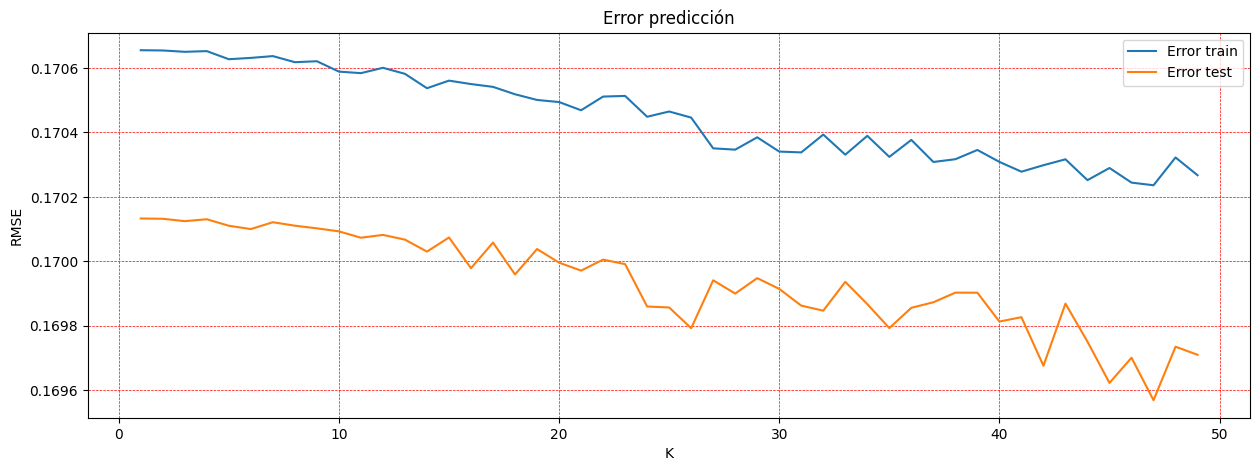

In [63]:
rmse_k(expo_carac,50, 'Error predicción')

5. Por último, utilice regresión lineal Bayesiana y grafique la media posterior y el intervalo de confianza de la distribución predictiva obtenida (use el mismo formato para graficar usado en el primero punto). Utilice diferentes valores para la varianza del prior sobre los parámetros, describa y explique los cambios observados.

In [64]:
def plot_distribution(x, media, var):
  # graficar media e intervalo de confianza

  x = x.flatten()
  media = media.flatten()
  var = var.flatten()
  conf = 2.0*np.sqrt(var) # intervalo de confianza

  plt.figure(figsize=(15,5))
  plt.plot(x, media, color="C0")
  plt.fill_between(x, media + conf, media - conf, alpha = 0.1, color="C0")
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.title("distribución de probabilidad");
  plt.show()

In [65]:
@interact(prior_var=(0.1,2,0.01))
# compute the feature matrix for the test inputs
def prior(prior_var):
  noise_var = sigma**2 # noise variance (sigma^2). We assume this is known.
  pol_deg=50
  Phi_test = expo_carac(Xtest, pol_deg) # N x (pol_deg+1) feature matrix SOLUTION

# compute the (marginal) prior at the test input locations
# prior mean
  prior_mean = np.zeros((len(Xtest),1)) # prior mean <-- SOLUTION

# prior variance
  full_covariance = Phi_test @ Phi_test.T * prior_var # N x N covariance matrix of all function values
  prior_marginal_var =  np.diag(full_covariance)

  plot_distribution(Xtest, prior_mean, prior_marginal_var)

interactive(children=(FloatSlider(value=1.05, description='prior_var', max=2.0, min=0.1, step=0.01), Output())…

In [66]:
## EDIT THIS FUNCTION

def polyfit(X, y, K, prior_var, noise_var):
    # X: training inputs, size N x D
    # y: training targets, size N x 1
    # K: degree of polynomial we consider
    # prior_var: prior variance of the parameter distribution
    # sigma: noise variance

    jitter = 1e-08 # increases numerical stability

    Phi = expo_carac(X, K) # N x (K+1) feature matrix

    # Compute maximum likelihood estimate
    Pt = Phi.T @ y # Phi*y, size (K+1,1)
    PP = Phi.T @ Phi + jitter*np.eye(K+1) # size (K+1, K+1)
    C = sp.linalg.cho_factor(PP)
    # maximum likelihood estimate
    theta_ml = sp.linalg.cho_solve(C, Pt) # inv(Phi^T*Phi)*Phi^T*y, size (K+1,1)

#     theta_ml = scipy.linalg.solve(PP, Pt) # inv(Phi^T*Phi)*Phi^T*y, size (K+1,1)

    # MAP estimate
    theta_map = sp.linalg.solve(PP + noise_var/prior_var*np.eye(K+1), Pt)

    # parameter posterior
    iSN = (np.eye(K+1)/prior_var + PP/noise_var) # posterior precision
    SN = sp.linalg.pinv(noise_var*np.eye(K+1)/prior_var + PP)*noise_var  # posterior covariance
    mN = sp.linalg.solve(iSN, Pt/noise_var) # posterior mean

    return (theta_ml, theta_map, mN, SN)

pol_deg=50
theta_ml, theta_map, theta_mean, theta_var = polyfit(Xtrain, ytrain, pol_deg, alpha, sigma)

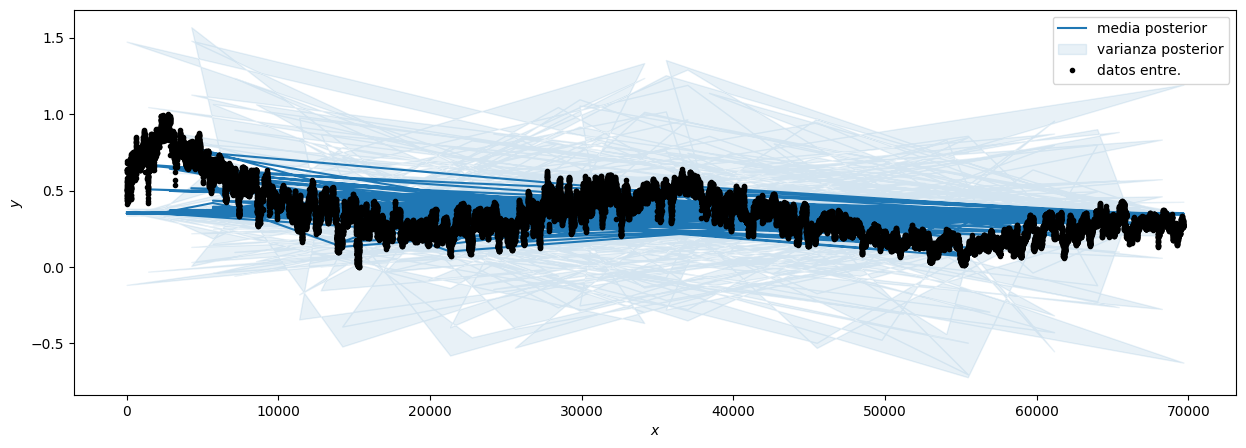

In [67]:
## EDIT THIS CELL

# predictions (ignoring the measurement/observations noise)

Phi_test = expo_carac(Xtest, pol_deg) # N x (K+1)

# maximum likelihood predictions (just the mean)
m_mle_test = Phi_test @ theta_ml

# MAP predictions (just the mean)
m_map_test = Phi_test @ theta_map

# predictive distribution (Bayesian linear regression)
# mean prediction
mean_blr = Phi_test @ theta_mean
# variance prediction
cov_blr =  Phi_test @ theta_var @ Phi_test.T

# plot the posterior
plt.figure(figsize=(15,5))
#plt.plot(Xtest, m_mle_test)
plt.plot(Xtest, m_map_test, 'C0')
var_blr = np.diag(cov_blr)
# conf_bound1 = np.sqrt(var_blr).flatten()
conf_bound2 = 2.0*np.sqrt(var_blr).flatten()
# conf_bound3 = 2.0*np.sqrt(var_blr + sigma).flatten()

# plt.fill_between(Xtest.flatten(), mean_blr.flatten() + conf_bound1,
                #  mean_blr.flatten() - conf_bound1, alpha = 0.1, color="k")
plt.fill_between(Xtest.flatten(), mean_blr.flatten() + conf_bound2,
                 mean_blr.flatten() - conf_bound2, alpha = 0.1, color="C0")
# plt.fill_between(Xtest.flatten(), mean_blr.flatten() + conf_bound3,
                #  mean_blr.flatten() - conf_bound3, alpha = 0.1, color="k")
plt.plot(Xtrain, ytrain, ".k")
plt.legend(["media posterior", "varianza posterior", "datos entre."])
plt.xlabel('$x$');
plt.ylabel('$y$');

La elección de la varianza del prior sobre los parámetros influye en la incertidumbre del modelo y, por lo tanto, va a afectar las predicciones.

Cuando se utiliza una varianza del prior alta, el prior se considera más disperso, lo que implica una mayor incertidumbre inicial sobre los parámetros del modelo. En este caso, el modelo puede ser más flexible y permitir ajustes más amplios a los datos de entrenamiento.

Por otro lado, cuando se utiliza una varianza del prior baja, el prior se considera más concentrado, lo que implica una menor incertidumbre inicial sobre los parámetros del modelo. En este caso, el modelo puede ser más restrictivo y tener un ajuste más ajustado a los datos de entrenamiento.

##**Conclusiones acerca de la regresión lineal Bayesiana:**


**Adaptabilidad**: La regresión lineal desde la perspectiva bayesiana destaca por su adaptabilidad, ya que puede integrar conocimientos a priori y gestionar la incertidumbre asociada a los parámetros del modelo de manera efectiva.

**Flexibilidad**: La regresión lineal bayesiana es un enfoque flexible que permite incorporar información previa y manejar la incertidumbre de los parámetros del modelo.

**Regularización**: A través del prior sobre los parámetros, la regresión lineal bayesiana proporciona una forma de regularización automática, lo que ayuda a evitar el sobreajuste y mejora la generalización del modelo.

**Prevención de sobreajuste**: La imposición de una distribución a priori sobre los parámetros actúa como un mecanismo de regularización intrínseca en la regresión lineal bayesiana, contribuyendo a la prevención del sobreajuste y favoreciendo la capacidad de generalización del modelo.

**Estimación de incertidumbre**: Además de las predicciones, la regresión lineal bayesiana proporciona estimaciones de incertidumbre asociadas con las predicciones, lo que puede ser útil en la toma de decisiones y el análisis de riesgo.

# Bibliografía
- Pattern Recognition and Machine Learning, Christopher M. Bishop. https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf (libro original gratis).

- Mathematics for Machine Learning, Marc Peter Deisenroth. https://mml-book.github.io/ (libro original gratis).

- Cuadernos del libro: Mathematics for Machine Learning. https://nbviewer.org/github/mml-book/mml-book.github.io/blob/master/tutorials/tutorial_linear_regression.ipynb